# Create constrained Q, U maps
## fixed T map and TE correlation

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['font.size'] = 15

In [2]:
def n_complex(n = 1, s = 1):
    return 1/np.sqrt(2)*np.random.randn(n) + 1.0j*1/np.sqrt(2)*np.random.randn(n)

In [18]:
def normalize_cl(cl):
    return np.array([l*(l+1)/(2*np.pi)*cl[l-1] for l in range(1,len(cl) + 1)])

## import Planck NILC T map

In [4]:
nilc = fits.open('maps/COM_CompMap_CMB-nilc_2048_R1.20.fits')

In [5]:
nilc.info()

Filename: maps/COM_CompMap_CMB-nilc_2048_R1.20.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   ()              
1    COMP-MAP    BinTableHDU     64   50331648R x 6C   [E, E, B, B, E, B]   
2    FGDS-LFI    BinTableHDU     51   12582912R x 3C   [E, E, E]   
3    FGDS-HFI    BinTableHDU     60   50331648R x 6C   [E, E, E, E, E, E]   
4                BinTableHDU     38   3200R x 1C   [E]   


In [6]:
T_nilc = hp.reorder(nilc[1].data.field(0), n2r = True)

In [23]:
nside = 512
T_nilc_trun = hp.pixelfunc.ud_grade(T_nilc, nside)

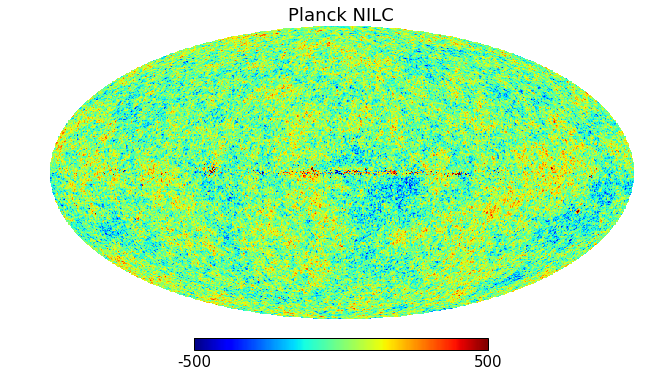

In [24]:
hp.mollview(T_nilc_trun, min = -500, max = 500, title = "Planck NILC")

In [25]:
alm_T = hp.map2alm(T_nilc_trun)

## import power spectra

In [10]:
file = '/global/u2/i/iameric/class/output/test_cl_lensed.dat'
data = np.loadtxt(file)
#for data_file in files:
#    data = np.loadtxt(data_file)

#1:l     2:TT      3:EE       4:TE      5:BB   6:phiphi       7:TPhi      8:Ephi
names = ['l','TT','EE','BB','TE','phiphi','Tphi','Ephi']

# l starts with 2 in class's output ps
# let Cl=0 when l = 1
def remove_norm(Cl):
    return np.array([2*np.pi*1/l/(l+1)*Cl[l-1] for l in range(1,1+len(Cl))])
l = data[:,0]
TT = remove_norm(np.insert(data[:,1],0,0))
EE = remove_norm(np.insert(data[:,2],0,0))
BB = remove_norm(np.insert(data[:,3],0,0))
TE = remove_norm(np.insert(data[:,4],0,0))

In [26]:
# use TT from the planck NILC map
TT = hp.anafast(T_nilc, lmax = 3000)

In [27]:
size = len(alm_T)
nlm = n_complex(size)

## create alm_E that is consistent with the TE, EE, and T map.
from the formula in BK1

$
\begin{equation}
a_{lm}^E = \frac{Cl^{TE}}{Cl^{TT}}a_{lm}^T + \sqrt{Cl^{EE} - (Cl^{TE})^2/Cl^{TT}} n_{lm}
\end{equation}
$

In [28]:
Alm = hp.Alm()
lmax = Alm.getlmax(len(alm_T))
alm_E = np.zeros_like(alm_T)
for i, alm in enumerate(alm_T):
    l = Alm.getlm(lmax, i)[0]
    alm_E[i] = TE[l-1]/TT[l-1]*alm_T[i] + np.sqrt(EE[l-1] - TE[l-1]**2/TT[l-1])*nlm[i]
    if alm_E[i] != alm_E[i]:
        alm_E[i] = 0

/global/u2/i/iameric/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


In [14]:
alm_B = hp.synalm(BB, lmax = lmax)

/global/homes/i/iameric/miniconda2/lib/python2.7/site-packages/healpy/sphtfunc.py:296: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


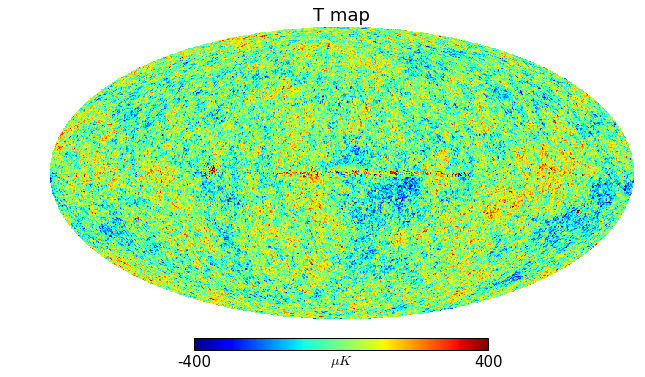

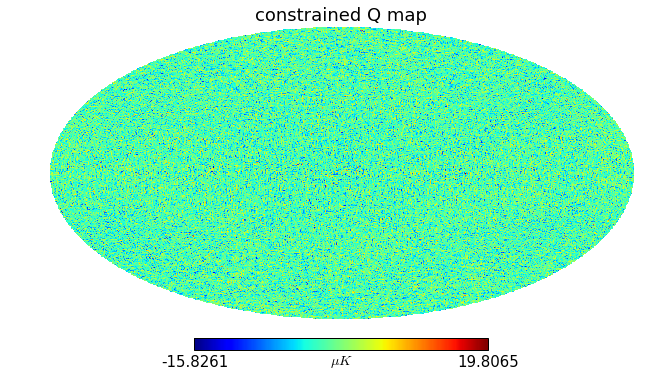

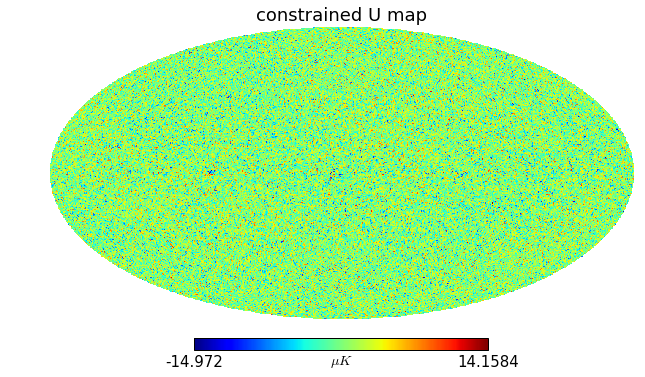

In [15]:
maps = hp.alm2map((alm_T, alm_E, alm_B), nside = 128)
hp.mollview(maps[0], title = 'T map', min = -400 ,max = 400, unit=r'$\mu K$')
hp.mollview(maps[1], title = 'constrained Q map', unit=r'$\mu K$')
hp.mollview(maps[2], title = 'constrained U map', unit=r'$\mu K$')

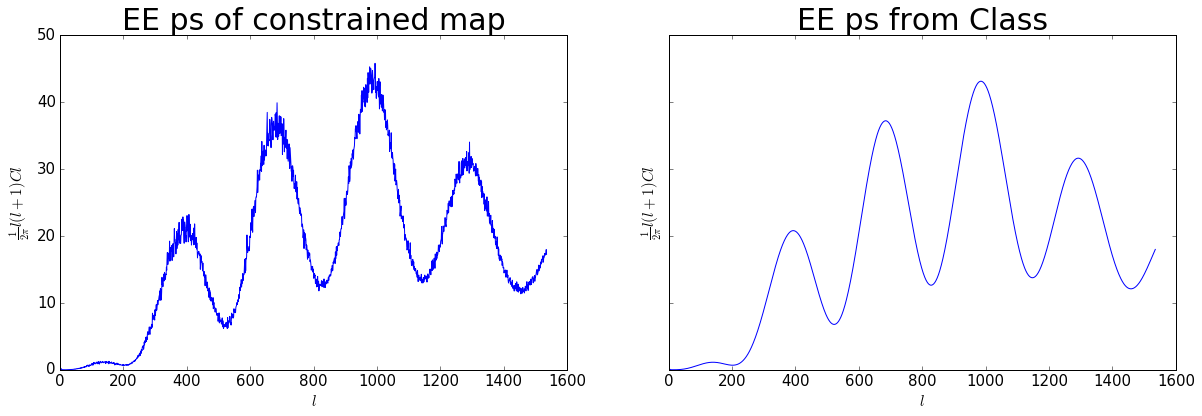

In [37]:
cl1 = normalize_cl(hp.alm2cl(alm_E))
cl2 = normalize_cl(EE)

f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize = (20,6))
ax1.plot(cl1, label = 'dT_dtheta')
ax2.plot(cl2[:len(cl1)], label = 'm A_lm')
ax1.set_title('EE ps of constrained map', fontsize = 30)
ax2.set_title('EE ps from Class', fontsize = 30)
ax1.set_xlabel(r'$l$')
ax2.set_xlabel(r'$l$')
ax1.set_ylabel(r'$\frac{1}{2 \pi}l(l+1)Cl$')
ax2.set_ylabel(r'$\frac{1}{2 \pi}l(l+1)Cl$')